This notebook simply reads and displays the available shapefiles for visual validation.

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
class AnalysisConfig:
    def __init__(self, shapefile_path='', stations_path=''):
        self.shapefile_path = shapefile_path
        self.stations_path = stations_path

In [3]:
STATIONS_DIR = '../data/exports'
SHAPEFILE_DIR = '../data/shapefiles/zipcodes'

config_sf = AnalysisConfig(
    shapefile_path = '{}/san_francisco.shp'.format(SHAPEFILE_DIR),
    stations_path = '{}/stations_san_francisco.csv'.format(STATIONS_DIR),
)

config_dc = AnalysisConfig(
    shapefile_path = '{}/washington_dc.shp'.format(SHAPEFILE_DIR),
    stations_path = '{}/stations_washington_dc.csv'.format(STATIONS_DIR),
)

In [4]:
CRS_PLOT = 'EPSG:4326'

def plot_stations(zips_gdf, stations_gdf):
    fig, ax = plt.subplots(figsize=(10, 10))
    zips_gdf.to_crs({'init': CRS_PLOT}).plot(ax=ax)
    stations_gdf.to_crs({'init': CRS_PLOT}).plot(ax=ax, color='orange')
    plt.show()

In [5]:
def load_gdfs(config):
    zips_gdf = gpd.read_file(config.shapefile_path)
    stations_df = pd.read_csv(config.stations_path)
    stations_gdf = gpd.GeoDataFrame(stations_df, geometry=gpd.points_from_xy(stations_df['lng'], stations_df['lat'])).set_crs('EPSG:4326')
    return (zips_gdf, stations_gdf)

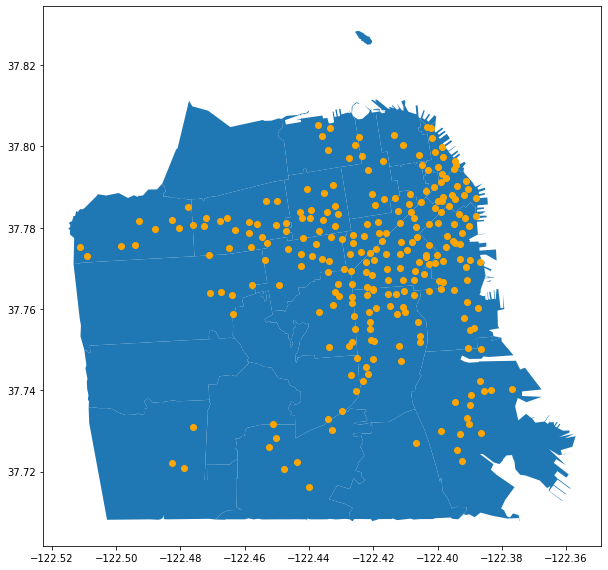

In [6]:
plot_stations(*load_gdfs(config_sf))

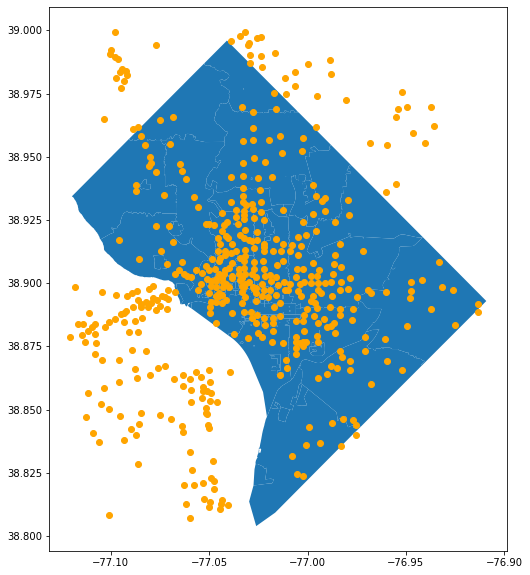

In [7]:
plot_stations(*load_gdfs(config_dc))